# googlenet

##### https://static.googleusercontent.com/media/research.google.com/zh-TW//pubs/archive/43022.pdf

## inception

![](inception.PNG)

## googlenet architecture

![](googlenet.PNG)

## tensorflow + googlenet

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.python.ops import array_ops

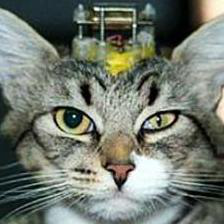

In [2]:
Image.open('./image.png')

In [3]:
image = np.asarray(Image.open('./image.png'))

image_y = np.zeros(4)
image_y[2] = 1

image = np.reshape(image, [-1, 224, 224, 3])
image_y = np.reshape(image_y, [-1, 4])

print (image.shape)
print (image_y)

(1, 224, 224, 3)
[[ 0.  0.  1.  0.]]


In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [5]:
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [6]:
def conv2d(x, W, s):
    return tf.nn.conv2d(input=x, filter=W, strides=[1, s, s, 1], padding='SAME')

In [7]:
def max_pool(x, k, s):
    return tf.nn.max_pool(x, ksize= [1, k, k, 1], strides=[1, s, s, 1], padding='SAME')
# stride [1, x_movement, y_movement, 1]

In [8]:
def avg_pool(x, k, s):
    return tf.nn.avg_pool(x, ksize= [1, k, k, 1], strides=[1, s, s, 1], padding='VALID')

In [9]:
def norm(x):
    return tf.nn.lrn(x, depth_radius=2, bias=2.0, alpha=1e-4, beta=0.75)

In [10]:
#計算準確度
def compute_accuracy(v_xs, v_ys):
    global prediction
    y_pre = sess.run(prediction, feed_dict={xs: v_xs, keep_prob: 1})
    
    print("After")
    poo=tf.shape(v_xs)
    poosee=tf.Session()
    print(poosee.run(poo))
    print("After")
    print("After")
    poo=tf.shape(y_pre)
    poosee=tf.Session()
    print(poosee.run(poo))
    print("After")
    print("After")
    poo=tf.shape(v_ys)
    poosee=tf.Session()
    print(poosee.run(poo))
    print("After")
    
    correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(v_ys,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    result = sess.run(accuracy, feed_dict={xs: v_xs, ys: v_ys, keep_prob: 1})
    return result

#
# v_xs: input
# v_ys: output
# keep_prob是保留概率，即我们要保留的结果所占比例
# 使输入tensor中某些元素變為0，其它没變0的元素變為原来的1/keep_prob大小！

## placeholder

In [11]:
# define placeholder for inputs to network
xs = tf.placeholder(tf.float32, [None, 224, 224, 3])  # 28x28
ys = tf.placeholder(tf.float32, [None, 4])
#keep_prob = tf.placeholder(tf.float32)
#x_image = tf.reshape(xs, [-1, 224, 224, 3])    #[n_samples個數,圖長,圖寬,圖高]
#print(x_image.shape)  # [n_samples, 28,28,1]

## googlenet

In [12]:
# conv maxpool lrn
W_conv1 = weight_variable([7,7,3,64])
b_conv1 = bias_variable([64])
r_conv1 = tf.nn.relu(conv2d(xs, W_conv1, 2) + b_conv1)
n_pool1 = max_pool(r_conv1, 3, 2)
n_norm1 = norm(n_pool1)

In [13]:
# conv conv lrn
W_conv2 = weight_variable([1,1,64,192])
b_conv2 = bias_variable([192])
r_conv2 = tf.nn.relu(conv2d(n_norm1, W_conv2, 1) + b_conv2)

W_conv3 = weight_variable([3,3,192,192])
b_conv3 = bias_variable([192])
r_conv3 = tf.nn.relu(conv2d(r_conv2, W_conv3, 1) + b_conv3)
n_norm3 = norm(r_conv3)

In [14]:
# maxpool
n_pool4 = max_pool(n_norm3, 3, 2)

In [15]:
def inception(net, all_in, o1, o2, o3, o4, o5, o6):
    #branch 0
    W_conv0 = weight_variable([1,1,all_in,o1])
    b_conv0 = bias_variable([o1])
    r_conv0 = tf.nn.relu(conv2d(net, W_conv0, 1) + b_conv0)
    
    #branch 1
    W_conv1_0 = weight_variable([1,1,all_in,o2])
    b_conv1_0 = bias_variable([o2])
    r_conv1_0 = tf.nn.relu(conv2d(net, W_conv1_0, 1) + b_conv1_0)   
    
    W_conv1_1 = weight_variable([3,3,o2,o3])
    b_conv1_1 = bias_variable([o3])
    r_conv1_1 = tf.nn.relu(conv2d(r_conv1_0, W_conv1_1, 1) + b_conv1_1) 
    
    #branch 2
    W_conv2_0 = weight_variable([1,1,all_in,o4])
    b_conv2_0 = bias_variable([o4])
    r_conv2_0 = tf.nn.relu(conv2d(net, W_conv2_0, 1) + b_conv2_0)   
    
    W_conv2_1 = weight_variable([5,5,o4,o5])
    b_conv2_1 = bias_variable([o5])
    r_conv2_1 = tf.nn.relu(conv2d(r_conv2_0, W_conv2_1, 1) + b_conv2_1) 
    
    #branch 3
    n_pool3_0 = max_pool(net, 3, 1)
    
    W_conv3_1 = weight_variable([1,1,all_in,o6])
    b_conv3_1 = bias_variable([o6])
    r_conv3_1 = tf.nn.relu(conv2d(n_pool3_0, W_conv3_1, 1) + b_conv3_1)  
    
    new_net = array_ops.concat([r_conv0, r_conv1_1, r_conv2_1, r_conv3_1], 3)
    
    return new_net

In [16]:
# inception 3a
inception_3a = inception(n_pool4, 192, 64, 96, 128, 16, 32, 32)

In [17]:
# inception 3b
inception_3b = inception(inception_3a, 256, 128, 128, 192, 32, 96, 64)

In [18]:
# maxpool
n_pool5 = max_pool(inception_3b, 3, 2)

In [19]:
# inception 4a
inception_4a = inception(n_pool5, 480, 192, 96, 208, 16, 48, 64)

In [20]:
# inception 4b
inception_4b = inception(inception_4a, 512, 160, 112, 224, 24, 64, 64)

In [21]:
# inception 4c
inception_4c = inception(inception_4b, 512, 128, 128, 256, 24, 64, 64)

In [22]:
# inception 4d
inception_4d = inception(inception_4c, 512, 112, 144, 288, 32, 64, 64)

In [23]:
# inception 4e
inception_4e = inception(inception_4d, 528, 256, 160, 320, 32, 128, 128)

In [24]:
# maxpool
n_pool6 = max_pool(inception_4e, 3, 2)

In [25]:
# inception 5a
inception_5a = inception(n_pool6, 832, 256, 160, 320, 32, 128, 128)

In [26]:
# inception 5b
inception_5b = inception(inception_5a, 832, 384, 192, 384, 48, 128, 128)

In [27]:
# avgpool
n_pool7 = avg_pool(inception_5b, 7, 1)

In [28]:
# fc
n_drop8 = tf.nn.dropout(n_pool7, keep_prob=0.7)
n_relu9 = tf.nn.relu(n_drop8)
n_relu9_reshape = tf.reshape(n_relu9, [-1, 1024])

W_fc = weight_variable([1024, 4])
b_fc = bias_variable([4])

prediction = tf.nn.softmax(tf.matmul(n_relu9_reshape, W_fc) + b_fc)

In [29]:
'''
# auxiliary classifier
def ac(net, _in, _out):
    # avgpool
    n_avgpool1 = avg_pool(net, 5, 3)
    
    # conv
    _W_conv1 = weight_variable([1,1,_in,_out])
    _b_conv1 = bias_variable([_out])
    _r_conv1 = tf.nn.relu(conv2d(n_avgpool1, _W_conv1, 1) + _b_conv1)
    
    # softmax
    _reshape = tf.reshape(_r_conv1, [-1, 4*_in*_out])
    
    _W_fc = weight_variable([4*_in*_out, 4])
    _b_fc = bias_variable([4])
    
    ac_pred = tf.nn.softmax(tf.matmul(_reshape, _W_fc) + _b_fc)
    
    return ac_pred

# auxiliary classifier (inception 4a)
ac_1_pred = ac(inception_4a, 512, 512)

# auxiliary classifier (inception 4d)
ac_2_pred = ac(inception_4d, 528, 528)

ac_loss_1 = tf.reduce_mean(tf.reduce_sum(tf.square(ys-ac_1_pred), reduction_indices=[1]))
ac_loss_1 = tf.losses.compute_weighted_loss(ac_loss_1, weights=0.3)

ac_loss_2 = tf.reduce_mean(tf.reduce_sum(tf.square(ys-ac_2_pred), reduction_indices=[1]))
ac_loss_2 = tf.losses.compute_weighted_loss(ac_loss_2, weights=0.3)

'''

'\n# auxiliary classifier\ndef ac(net, _in, _out):\n    # avgpool\n    n_avgpool1 = avg_pool(net, 5, 3)\n    \n    # conv\n    _W_conv1 = weight_variable([1,1,_in,_out])\n    _b_conv1 = bias_variable([_out])\n    _r_conv1 = tf.nn.relu(conv2d(n_avgpool1, _W_conv1, 1) + _b_conv1)\n    \n    # softmax\n    _reshape = tf.reshape(_r_conv1, [-1, 4*_in*_out])\n    \n    _W_fc = weight_variable([4*_in*_out, 4])\n    _b_fc = bias_variable([4])\n    \n    ac_pred = tf.nn.softmax(tf.matmul(_reshape, _W_fc) + _b_fc)\n    \n    return ac_pred\n\n# auxiliary classifier (inception 4a)\nac_1_pred = ac(inception_4a, 512, 512)\n\n# auxiliary classifier (inception 4d)\nac_2_pred = ac(inception_4d, 528, 528)\n\nac_loss_1 = tf.reduce_mean(tf.reduce_sum(tf.square(ys-ac_1_pred), reduction_indices=[1]))\nac_loss_1 = tf.losses.compute_weighted_loss(ac_loss_1, weights=0.3)\n\nac_loss_2 = tf.reduce_mean(tf.reduce_sum(tf.square(ys-ac_2_pred), reduction_indices=[1]))\nac_loss_2 = tf.losses.compute_weighted_loss(ac

In [30]:
cross_entropy = tf.reduce_mean(tf.reduce_sum(tf.square(ys-prediction), reduction_indices=[1]))
lr = 0.01
train_step = tf.train.MomentumOptimizer(learning_rate=lr, momentum=0.9).minimize(cross_entropy)

In [31]:
correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(ys,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [32]:
def print_filter(layer, filter_size, num):
    i = 0
    filter_no = 0
    _print = ''
    
    for i in range(filter_size):
        _print = ''
        for j in range(filter_size):
            _print = _print + str(sess.run(layer[i,j,num,0])) + '\t'
        print (_print)

In [33]:
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

In [34]:
for i in range(1000):
    sess.run(train_step, feed_dict={xs:image, ys:image_y})
    if i == 1:
        print_filter(W_conv1, 7, 2)
    if i % 8 == 0:
        lr = lr * 0.96
    if i % 100 ==0:
        train_accuracy = sess.run(accuracy, feed_dict={xs:image, ys:image_y})
        train_loss = sess.run(cross_entropy, feed_dict={xs:image, ys:image_y})
        print("epoch: {}, training accuracy: {:.12f}, loss: {:.6f}".format(i, train_accuracy, train_loss))
        print (sess.run(prediction, feed_dict={xs:image, ys:image_y}))
    

epoch: 0, training accuracy: 1.000000000000, loss: 0.000000
[[ 0.  0.  1.  0.]]
0.0837934	-0.154265	0.0541995	-0.142516	0.0103223	0.0206707	-0.0855166	
-0.0809563	-0.0238615	0.101704	0.131933	-0.0691611	0.0133641	0.0382756	
0.117382	-0.0281298	-0.0342319	-0.0518356	0.059355	0.0152958	-0.121288	
-0.0147252	0.0282011	0.0457106	0.120991	-0.124597	-0.0433385	0.0404815	
0.0257547	0.0284509	-0.0204669	0.0342921	0.0488025	-0.019467	-0.153851	
0.117443	-0.0347777	-0.0335785	-0.0810315	0.00680713	-0.00541996	0.1255	
-0.0874093	0.00044906	-0.101047	0.0102986	-0.0859887	0.0302187	-0.0525921	
epoch: 100, training accuracy: 1.000000000000, loss: 2.000000
[[ 0.  0.  1.  0.]]
epoch: 200, training accuracy: 1.000000000000, loss: 2.000000
[[ 0.  1.  0.  0.]]
epoch: 300, training accuracy: 1.000000000000, loss: 0.000000
[[ 0.  0.  1.  0.]]
epoch: 400, training accuracy: 1.000000000000, loss: 0.000000
[[ 0.  0.  1.  0.]]
epoch: 500, training accuracy: 1.000000000000, loss: 2.000000
[[ 0.  0.  1.  0.]]
ep

In [35]:
print_filter(W_conv1, 7, 2)

0.0837934	-0.154265	0.0541995	-0.142516	0.0103223	0.0206707	-0.0855166	
-0.0809563	-0.0238615	0.101704	0.131933	-0.0691611	0.0133641	0.0382756	
0.117382	-0.0281298	-0.0342319	-0.0518356	0.059355	0.0152958	-0.121288	
-0.0147252	0.0282011	0.0457106	0.120991	-0.124597	-0.0433385	0.0404815	
0.0257547	0.0284509	-0.0204669	0.0342921	0.0488025	-0.019467	-0.153851	
0.117443	-0.0347777	-0.0335785	-0.0810315	0.00680713	-0.00541996	0.1255	
-0.0874093	0.00044906	-0.101047	0.0102986	-0.0859887	0.0302187	-0.0525921	
